In [0]:
# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install -q pydot
import pydot

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

Using TensorFlow backend.


In [0]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [0]:
# MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

11501568/11490434 [==============================] - 1s 0us/step


In [0]:
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

In [0]:
# VAE の実装
# 入力層　→　平均 & 分散
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
# 平均 & 分散になると仮定
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# reparameterization trick 用の層を追加
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Encoder
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# Decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# VAE 全体をモデル化する
z_output = encoder(inputs)[2]
outputs = decoder(z_output)
vae = Model(inputs, outputs, name='vae_mlp')

W0918 06:49:30.619492 139738515720064 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0918 06:49:30.663532 139738515720064 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0918 06:49:30.665255 139738515720064 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0918 06:49:30.830991 139738515720064 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

In [0]:
data = (x_test, y_test)

# Reconstruction Loss
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= original_dim

# Kullback-Leibler Loss
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

plot_model(vae,
               to_file='vae_mlp.png',
               show_shapes=True)

vae.fit(x_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test, None))

W0918 06:49:31.217464 139738515720064 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


W0918 06:49:31.495640 139738515720064 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 8s 140us/step - loss: 51.7254 - val_loss: 44.1980
Epoch 2/50
60000/60000 [==============================] - 4s 64us/step - loss: 43.3090 - val_loss: 42.6237
Epoch 3/50
60000/60000 [==============================] - 4s 64us/step - loss: 42.3038 - val_loss: 41.9375
Epoch 4/50
60000/60000 [==============================] - 4s 64us/step - loss: 41.6301 - val_loss: 41.3273
Epoch 5/50
60000/60000 [==============================] - 4s 64us/step - loss: 41.0827 - val_loss: 40.8477
Epoch 6/50
60000/60000 [==============================] - 4s 62us/step - loss: 40.6547 - val_loss: 40.5962
Epoch 7/50
60000/60000 [==============================] - 4s 63us/step - loss: 40.3110 - val_loss: 40.2531
Epoch 8/50
60000/60000 [==============================] - 4s 63us/step - loss: 40.0195 - val_loss: 39.8584
Epoch 9/50
60000/60000 [==============================] - 4s 63us/step - loss: 39.7368 - val_

In [0]:
import matplotlib.cm as cm

def plot_results(encoder,
                 decoder,
                 x_test,
                 y_test,
                 batch_size=128,
                 model_name="vae_mnist"):

    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    cmap=cm.tab10
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=cmap(y_test))
    m = cm.ScalarMappable(cmap=cmap)
    m.set_array(y_test)

    plt.colorbar(m)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

    
    #
    # (-4, -4) から (4, 4) までを30x30分割してプロットする
    #
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.axis('off')
    plt.imshow(figure, cmap='Greys_r')
    #plt.savefig(filename)
    plt.show()

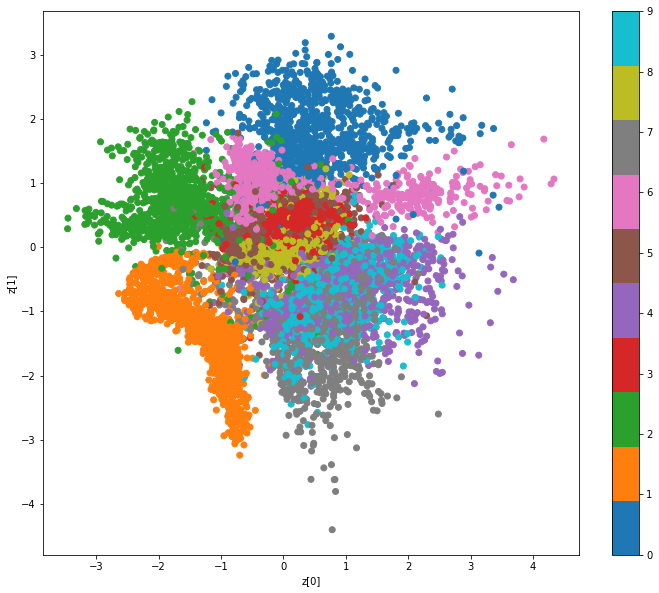

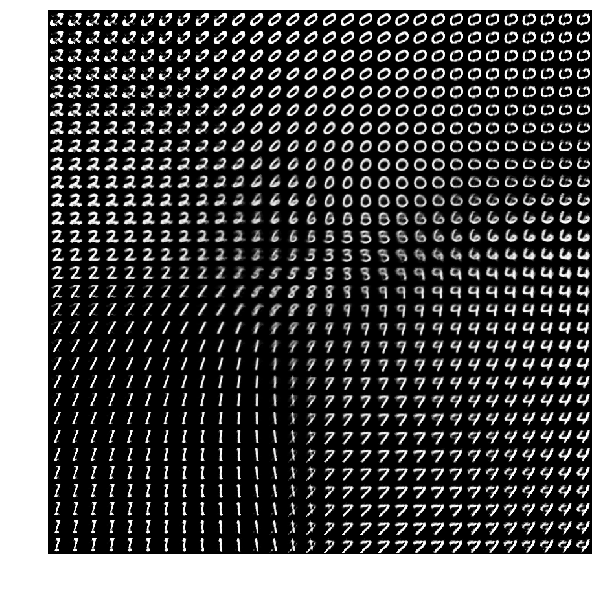

In [0]:

plot_results(encoder,
                 decoder,
                 x_test,
                 y_test,
                 batch_size=batch_size,
                 model_name="vae_mlp")